# Exercise with A/B Testing

### Prompt

Let’s imagine you work on the For You Page at TikTok. Your team decides that instead of a heart button, they want to change it to star hoping that it will lead to a higher engagement/like rate. The product manager told you that the current conversion rate is about 6% on average throughout the year, and that the team would be happy with an increase of 3%, meaning that the new design will be considered a success if it raises the engagement rate to 9%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base users.

In [1]:
# Packages imports
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats
# estimating statistical models
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

#rounding function
from math import ceil



### Sample Size Calculation

In [2]:
# Calculate effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.06, 0.09)

In [3]:
# Calculate sample size needed

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  


required_n = ceil(required_n)                                               
print(required_n)

1199


### Collecting and preparing the data

In [4]:
# Load the tiktok_data.csv into a dataframe

df = pd.read_csv('tiktok_data.csv')
df.head()


,user_id,timestamp,group,button,liked
0,767017,2017-01-12 22:58:15,control,star,0
1,793849,2017-01-23 22:36:11,treatment,star,0
2,905617,2017-01-20 14:12:19,treatment,star,0
3,746742,2017-01-23 11:38:30,control,heart,0
4,892356,2017-01-05 9:35:15,treatment,star,1


In [5]:
# Get the info of the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275781 entries, 0 to 275780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    275781 non-null  int64 
 1   timestamp  275781 non-null  object
 2   group      275781 non-null  object
 3   button     275781 non-null  object
 4   liked      275781 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 10.5+ MB


In [7]:
# Make sure all the control group are seeing the star button and viceversa

pd.crosstab(df['group'], df['button'])

df['button'] = np.where(df['group'] == 'control', 'star', 'heart')

pd.crosstab(df['group'], df['button'])

button,heart,star
group,,
control,0,137818
treatment,137963,0


In [8]:
# Check that no users have been sampled multiple times 

session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

In [10]:
# If there are users who have been sampled multiple times, remove them from the dataframe
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(df.shape[0])

268875


#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [12]:
# Perform simple random sampling to split the data into control and treatment

control_sample = df[df['group'] == 'control'].sample(n= 4720, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n= 4720, random_state=22)

In [13]:
# Create one table called ab_test that has both the cleaned control and treatment data

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,button,liked
0,644761,2017-01-20 5:19:16,control,star,0
1,856804,2017-01-02 23:19:00,control,star,0
2,728826,2017-01-03 4:16:37,control,star,0
3,865441,2017-01-19 3:59:57,control,star,0
4,796969,2017-01-05 4:08:26,control,star,0
...,...,...,...,...,...
9435,823616,2017-01-15 1:47:04,treatment,heart,0
9436,924407,2017-01-07 12:54:20,treatment,heart,1
9437,749158,2017-01-06 21:42:04,treatment,heart,0
9438,677299,2017-01-16 14:04:14,treatment,heart,0


In [14]:
# Count the test groups to make sure that they're balanced 

ab_test['group'].value_counts()



treatment    4720
control      4720
Name: group, dtype: int64

### Analysis Visualization

In [17]:
# Find the like rate by group

conversion_rates = ab_test.groupby('group')['liked']

# Find the Std. deviation of the proportion

std_p = lambda x: np.std(x)

# Find the Std. error of the proportion (std / sqrt(n))

se_p = lambda x: stats.sem(x) 

# Calculate the final like rate
conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.121,0.326,0.005
treatment,0.125,0.330,0.005


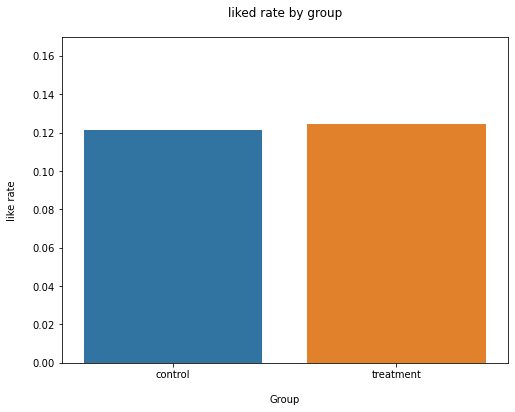

In [19]:
# Plot the like rate by group on a bar plot

plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['liked'], ci=False)

plt.ylim(0, 0.17)
plt.title('liked rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('like rate', labelpad=15);

### Testing for Stat Sig

In [22]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Get the like count for both control and treatment groups

control_results = ab_test[ab_test['group'] == 'control']['liked']
treatment_results = ab_test[ab_test['group'] == 'treatment']['liked']


# Get the number of samples in both groups

n_con = control_results.count()
n_treat = treatment_results.count()

# Sum up the number of successes (likes) in both groups

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]


print(successes)


[572, 588]


In [23]:
# Find the z statistic and p value for proportions based on normal ztest

z_stat, pval = proportions_ztest(successes, nobs=nobs)

# Find the confidence intervals for each test group
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)


In [24]:
# print z statistic

print(f'z statistic: {z_stat:.2f}') 

# print p-value

print(f'p-value: {pval:.3f}')

# print ci 95% for control group

print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')

# print ci 95% for treatment group
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.50
p-value: 0.616
ci 95% for control group: [0.112, 0.130]
ci 95% for treatment group: [0.115, 0.134]


### Were the results signficant? 

In [26]:
print('no, the results are not statistically significant because the p value is greater than our threshold of 0.05')


no, the results are not statistically significant because the p value is greater than our threshold of 0.05


### What would you advise the engineering team to do moving forward?

In [27]:
print('they should move on and not chnage the buttons or make an entrly new feature that could be more statistically signif')

try a differnt feature
